In [1]:
# !pip install torch
# !pip install torchvision

In [1]:
import warnings

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# Data Definition

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.1307,),
            (0.3801),
        ),
    ]
)

In [3]:
train_set = datasets.MNIST(
    root="./data",
    train=True,
    download=False,
    transform=transform,
)

test_set = datasets.MNIST(
    root="./data",
    train=False,
    download=False,
    transform=transform,
)

In [4]:
train_loader = DataLoader(
    train_set,
    batch_size=64,
    shuffle=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=1000,
    shuffle=False,
)

# Architecture

In [ ]:
# --- Residual Block ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # 첫 번째 convolution layer
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 두 번째 convolution layer
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # skip connection 경로: 입력과 출력 채널 수/stride가 다를 경우 조정
        self.shortcut = nn.Sequential()

        ## 텐서 크기가 다른 경우 그냥 더할 수 없기 때문에 Conv 레이어 통해 맞춰줌 -> 변환 연산
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        # 기본 경로: Conv -> BN -> ReLU -> Conv -> BN
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # 입력을 더하는 skip connection
        out += self.shortcut(x)

        return F.relu(out)

In [ ]:
# --- ResNet for MNIST ---
class ResNetMNIST(nn.Module):
    def __init__(self):
        super(ResNetMNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = ResidualBlock(16, 16)
        self.layer2 = ResidualBlock(16, 32, stride=2)
        self.layer3 = ResidualBlock(32, 64, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

# Training & Testing Functions

In [7]:
train_losses = []
test_accuracies = []

In [ ]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}\tLoss: {loss.item():.6f}"
            )

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

In [ ]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    test_accuracies.append(accuracy)

    print(
        f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n"
    )

In [10]:
# --- Run Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetMNIST().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, criterion, epoch)
    test(model, device, test_loader, criterion)

Train Epoch: 1 [0/60000	Loss: 2.373567
Train Epoch: 1 [6400/60000	Loss: 0.674502
Train Epoch: 1 [12800/60000	Loss: 0.332137
Train Epoch: 1 [19200/60000	Loss: 0.099404
Train Epoch: 1 [25600/60000	Loss: 0.064545
Train Epoch: 1 [32000/60000	Loss: 0.097434
Train Epoch: 1 [38400/60000	Loss: 0.111015
Train Epoch: 1 [44800/60000	Loss: 0.064754
Train Epoch: 1 [51200/60000	Loss: 0.117620
Train Epoch: 1 [57600/60000	Loss: 0.113601

Test set: Average loss: 0.0001, Accuracy: 9584/10000 (95.84%)

Train Epoch: 2 [0/60000	Loss: 0.099644
Train Epoch: 2 [6400/60000	Loss: 0.053664
Train Epoch: 2 [12800/60000	Loss: 0.033107
Train Epoch: 2 [19200/60000	Loss: 0.030053
Train Epoch: 2 [25600/60000	Loss: 0.017019
Train Epoch: 2 [32000/60000	Loss: 0.014436
Train Epoch: 2 [38400/60000	Loss: 0.131935
Train Epoch: 2 [44800/60000	Loss: 0.020872
Train Epoch: 2 [51200/60000	Loss: 0.029394
Train Epoch: 2 [57600/60000	Loss: 0.088458

Test set: Average loss: 0.0000, Accuracy: 9865/10000 (98.65%)

Train Epoch: 3 [0/6000

## Results

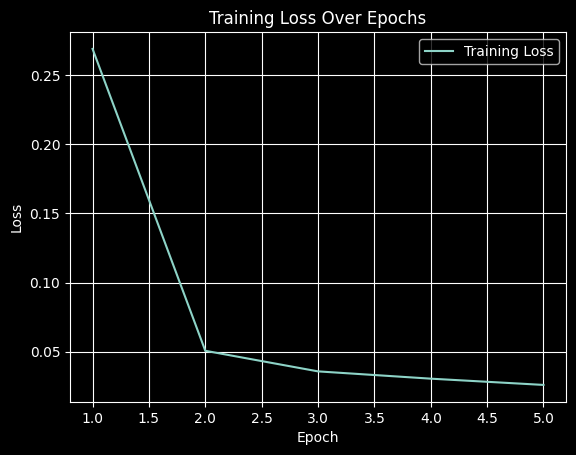

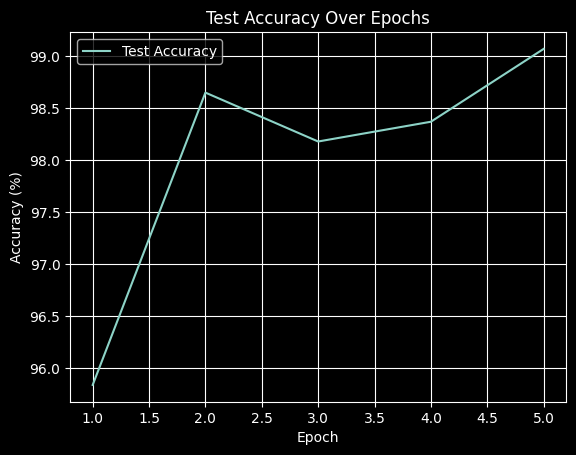

In [ ]:
# --- Plot Training Loss and Test Accuracy ---
epochs = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# End of Documents